# Visualizing gzip

How the hell does it even work?

In [17]:
import gzip
import contextlib
import pandas
import os
import io
import matplotlib
import matplotlib.pyplot as pyplot

In [18]:
os.getcwd()

'/Users/hum/fun/git/hum/visual-gzip'

In [19]:
!gzip -k files/harry.txt
!ls -lh files/

total 1200
-rw-r--r--@ 1 hum  staff   438K Sep 23 10:51 harry.txt
-rw-r--r--@ 1 hum  staff   159K Sep 23 10:51 harry.txt.gz


In [20]:
compressed = open('files/harry.txt.gz', 'rb')
gzip_file = gzip.GzipFile(fileobj=compressed)

In [21]:
read_bytes = gzip_file.read(200)
print(read_bytes)

b"Harry Potter and the Sorcerer's Stone \r\n\r\nCHAPTER ONE \r\n\r\nTHE BOY WHO LIVED \r\n\r\nMr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very mu"


In [22]:
compressed.tell()

258

In [23]:
read_bytes = gzip_file.read(200)
print(read_bytes)

b"ch. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense. \r\n\r\nMr. Dursley was the director of a firm called Grunnin"


In [24]:
compressed.tell()

392

In [25]:
# setting python's buffer size to 1
import io
io.DEFAULT_BUFFER_SIZE = 8192
old_buffer_size = io.DEFAULT_BUFFER_SIZE
io.DEFAULT_BUFFER_SIZE = 1

gzip_file.close()
compressed.close()
compressed = open('files/harry.txt.gz', 'rb', buffering = 0)
gzip_file = gzip.GzipFile(fileobj=compressed)

In [26]:
gzip_file.read(200)

b"Harry Potter and the Sorcerer's Stone \r\n\r\nCHAPTER ONE \r\n\r\nTHE BOY WHO LIVED \r\n\r\nMr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very mu"

In [27]:
compressed.tell()

258

In [28]:
bytes_uncompressed = 100

for _ in range(5):
    gzip_file.read(100)
    bytes_uncompressed += 100
    bytes_compressed = compressed.tell()
    print(f'Uncompressed: {bytes_uncompressed}B --- Compressed: {bytes_compressed}B')

Uncompressed: 200B --- Compressed: 328B
Uncompressed: 300B --- Compressed: 392B
Uncompressed: 400B --- Compressed: 458B
Uncompressed: 500B --- Compressed: 510B
Uncompressed: 600B --- Compressed: 572B


In [29]:
gzip_file.close()
compressed.close()
io.DEFAULT_BUFFER_SIZE = old_buffer_size

In [30]:
@contextlib.contextmanager
def buffer_size(size=1):
    old_buffer_size = io.DEFAULT_BUFFER_SIZE
    io.DEFAULT_BUFFER_SIZE = size
    
    try:
        yield
    finally:
        io.DEFAULT_BUFFER_SIZE = old_buffer_size

In [31]:
with buffer_size():
    print(f'Size: {io.DEFAULT_BUFFER_SIZE}')
print(f'Size: {io.DEFAULT_BUFFER_SIZE}')


Size: 1
Size: 8192


In [32]:
def create_curve(filename: str, chunksize = 64):
    records = []
    read = 0
    
    with buffer_size(), open(filename, 'rb') as file_:
        zipped = gzip.GzipFile(fileobj = file_)
        data = zipped.read(chunksize)
        
        while len(data) > 0:
            read += len(data)
            records.append((read, file_.tell()))
            data = zipped.read(chunksize)
            
    data_frame = pandas.DataFrame(records, columns=['Uncompressed', filename])
    return data_frame.set_index('Uncompressed')

In [33]:
compression_curve = create_curve('files/harry.txt.gz')
compression_curve

,files/harry.txt.gz
Uncompressed,
64,157
128,209
192,252
256,294
320,341
...,...
448576,163021
448640,163037
448704,163066


<AxesSubplot:xlabel='Uncompressed'>

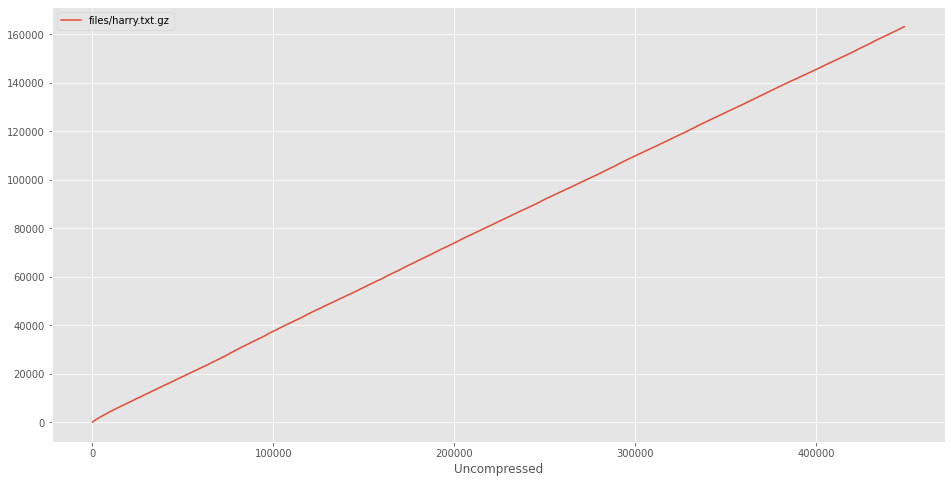

In [34]:
pyplot.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [16, 8]

compression_curve.plot()

<AxesSubplot:xlabel='Uncompressed'>

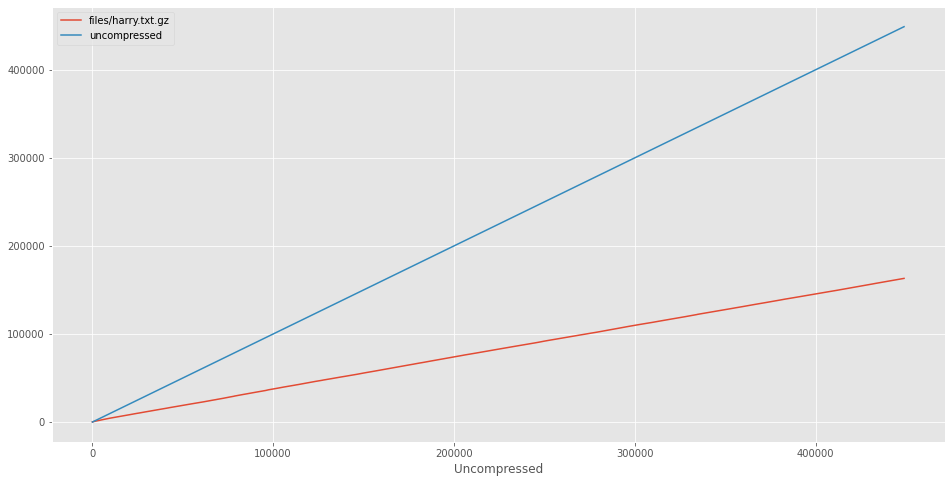

In [35]:
compression_curve['uncompressed'] = compression_curve.index
compression_curve.plot()

### notes
-# --fast --best
          Regulate the speed of compression using the specified digit #, where -1
          or  --fast  indicates the fastest compression method (less compression)
          and -9 or --best indicates the slowest compression  method  (best  com‐
          pression).   The  default  compression level is -6 (that is, biased to‐
          wards high compression at expense of speed).

## Using compression curve to compare compression levels

In [36]:
files = []

for level in range(1, 10):
    os.system(f'gzip -k -S .gz.{level} -{level} files/harry.txt')
    files.append(f'files/harry.txt.gz.{level}')
    print(f'Compressed file with level {level}')

Compressed file with level 1
Compressed file with level 2
Compressed file with level 3
Compressed file with level 4
Compressed file with level 5
Compressed file with level 6
Compressed file with level 7
Compressed file with level 8
Compressed file with level 9


In [40]:
compression_curve = pandas.concat([create_curve(f) for f in files], axis=1)

<AxesSubplot:title={'center':'Gzip compression for individual levels'}, xlabel='Uncompressed'>

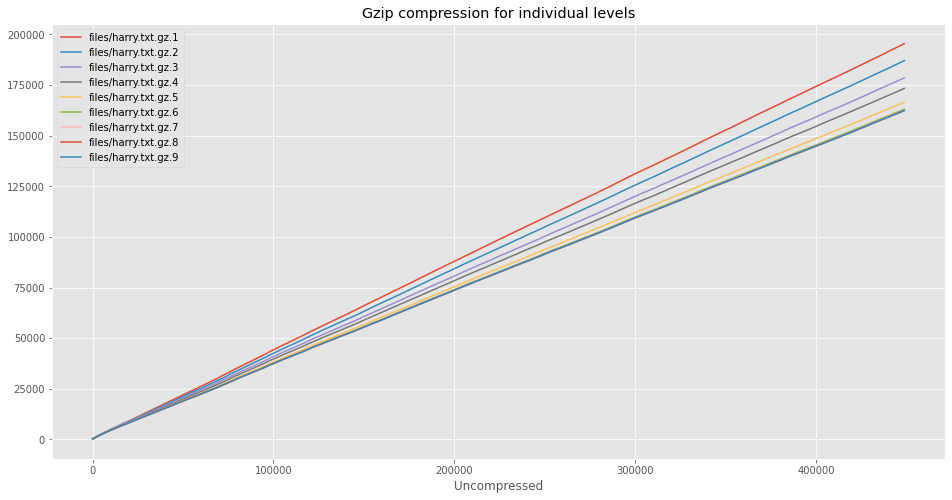

In [42]:
compression_curve.plot(title='Gzip compression for individual levels')

<AxesSubplot:xlabel='Uncompressed'>

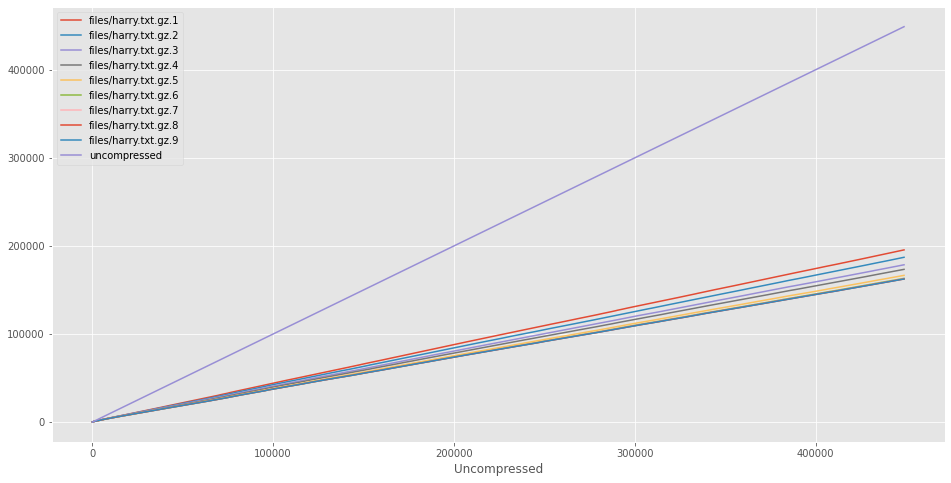

In [43]:
compression_curve['uncompressed'] = compression_curve.index
compression_curve.plot()